In [2]:
import pandas as pd
import numpy as np
import prework as pwk
import string
from time import time

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.grid_search import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import recall_score, accuracy_score, precision_score, roc_auc_score
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models.doc2vec import LabeledSentence, Doc2Vec
from collections import Counter

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import spacy
spc_nlp = spacy.load('en')

In [4]:
root = 'data/ICNALE/Unmerged_classified'
#root = 'data/pilot3'

In [5]:
df_orig = pwk.load_data_multi(root)
df_orig.head(1)

5600


,doc_id,path,author_code,essay_content,label
0,1,data/ICNALE/Unmerged_classified/ICNALE_W_CHN_A...,W_CHN_PTJ0_021_A2_0.txt,﻿I agree that it is important for college stud...,CHN


In [6]:
cond = (df_orig['label']=='HKG')|(df_orig['label']=='TWN')
df_0 = df_orig.drop(df_orig[cond].index, axis=0)

In [7]:
countries = list(df_0.groupby('label').size().index)
sample_count = df_0.groupby('label').size().values

In [7]:
countries

['CHN', 'ENS', 'IDN', 'JPN', 'KOR', 'PAK', 'PHL', 'SIN', 'THA']

/Users/ziru/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


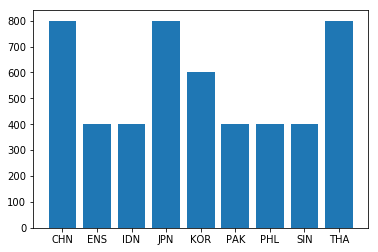

In [8]:
fig, ax = plt.subplots()
ax.bar(range(len(countries)), sample_count)
#ax.xticks = countries
plt.xticks(range(len(countries)), countries)
#fig.set_size_inches(18.5, 10.5, forward=True)
fig.show()

In [9]:
X = df_0['essay_content']
y = df_0['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5)

In [10]:
vectorizer = TfidfVectorizer(lowercase=True)
X_train_dtm = vectorizer.fit_transform(X_train)
X_test_dtm = vectorizer.transform(X_test)

In [11]:
X_train_dtm.shape

(2500, 11225)

In [12]:
clf = LogisticRegression()
#clf.fit(X_train_dtm[120:140], y_train[120:140])
clf.fit(X_train_dtm, y_train)
y_pred = clf.predict(X_test_dtm)

In [13]:
#clf.coef_

In [14]:
accuracy_score(y_test, y_pred)

0.82720000000000005

In [59]:
pipeline_lgr = Pipeline([
    ('vect', TfidfVectorizer(lowercase=True, max_features=900)),
    ('clf', LogisticRegression())
])
scores = cross_val_score(pipeline_lgr, X_train, y_train, cv=5)
print scores

[ 0.80318091  0.80079681  0.8003992   0.80321285  0.82258065]


In [27]:
pipeline_mnb = Pipeline([
    ('vect', CountVectorizer(lowercase=True, max_features=900)),
    ('clf', MultinomialNB())
])
scores = cross_val_score(pipeline_mnb, X_train, y_train, cv=5)
print scores

[ 0.8250497   0.83101392  0.85        0.82128514  0.83467742]


In [55]:
pipeline_rf = Pipeline([
    ('vect', TfidfVectorizer(lowercase=True, max_features=900)),
    ('clf', RandomForestClassifier(n_estimators=100))
])
scores = cross_val_score(pipeline_rf, X_train, y_train, cv=5)
print scores

[ 0.70178926  0.71115538  0.68463074  0.68072289  0.72782258]


In [60]:
pipeline_svm = Pipeline([
    ('vect', TfidfVectorizer(lowercase=True, max_features=900)),
    ('clf', LinearSVC())
])
scores = cross_val_score(pipeline_svm, X_train, y_train, cv=5)
print scores

[ 0.87077535  0.86454183  0.86826347  0.86746988  0.89314516]


# Feature Extraction

## POS tags

In [17]:
df_0['DT_pos'] = df_0['essay_content'].apply(lambda x: [' '.join([token.pos_ for token in spc_nlp(s.text)]) for s in spc_nlp(x.decode('utf-8')).sents])

### Repetition of adjective

In [55]:
df_0['POS_adjv_body'] = df_0['essay_content'].apply(lambda x: [token.text.lower() for token in spc_nlp(x.decode('utf-8')) if (token.dep_=='amod')|(token.dep_=='advmod')])    

In [ ]:
df_0['POS_adjv_body'][:50].apply(lambda x: Counter(x).most_common(len(Counter(x).keys())/9)) # Get top 1/9 most common terms

In [ ]:
df_0['POS_adjv_repeat'] = df_0['POS_adjv_body'].apply(lambda x: len([k for k, v in dict(Counter(x)).iteritems() if v>1])*1./len(x))

In [ ]:
df_0['POS_adjv_repeat_sum'] = df_0['POS_adjv_body'].apply(lambda x: sum([v for k, v in dict(Counter(x)).iteritems() if v>1]))


In [234]:
#df_0.to_pickle('df_syntactic_20180109.pkl')

In [235]:
df_0.head(2)

,doc_id,path,author_code,essay_content,label,DT_max_dp_cnts,DT_archs,DT_ROOT_idx,DT_pass_cnt,DT_mark_cnt,POS_adjv_body,DT_pos,DT_pos_join,DT_archs_join
0,1,data/ICNALE/Unmerged_classified/ICNALE_W_CHN_A...,W_CHN_PTJ0_021_A2_0.txt,﻿I agree that it is important for college stud...,CHN,"[4, 6, 6, 8, 8, 5, 4, 6, 8, 4, 5, 7, 6]",[nsubj ROOT mark nsubj ccomp acomp mark compou...,"[1, 9, 3, 16, 8, 8, 1, 3, 7, 1, 11, 2, 4]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[2, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0]","[apart, nowadays, large, well, many, when, the...",[NOUN VERB ADP PRON VERB ADJ ADP NOUN NOUN PAR...,NOUN VERB ADP PRON VERB ADJ ADP NOUN NOUN PART...,nsubj ROOT mark nsubj ccomp acomp mark compoun...
1,2,data/ICNALE/Unmerged_classified/ICNALE_W_CHN_A...,W_CHN_PTJ0_022_A2_0.txt,"﻿In the last years, college students taking a ...",CHN,"[7, 4, 4, 3, 5, 5, 5, 5, 4, 6, 6, 7, 8, 9]",[aux det amod npadvmod punct compound nsubj ac...,"[13, 2, 2, 1, 3, 6, 8, 5, 2, 3, 2, 4, 11, 4]","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1]","[0, 2, 0, 0, 1, 0, 1, 0, 0, 2, 0, 0, 1, 0]","[last, very, big, many, firstly, most, importa...",[VERB DET ADJ NOUN PUNCT NOUN NOUN VERB DET AD...,VERB DET ADJ NOUN PUNCT NOUN NOUN VERB DET ADJ...,aux det amod npadvmod punct compound nsubj acl...


### POS ngram

In [22]:
df_0.DT_pos[0]

[u'NOUN VERB ADP PRON VERB ADJ ADP NOUN NOUN PART VERB ADV PUNCT NOUN NOUN PUNCT',
 u'ADV PUNCT DET ADJ NOUN ADP NOUN NOUN VERB VERB DET ADJ PUNCT NOUN NOUN PUNCT',
 u'DET ADP PRON VERB DET NOUN PUNCT NOUN NOUN VERB VERB PRON PART VERB ADP DET NOUN ADV CCONJ VERB PRON ADJ NOUN PUNCT',
 u'VERB DET NOUN ADP NOUN ADP NOUN PUNCT ADV PROPN VERB DET NOUN NOUN PUNCT PRON VERB ADP NOUN ADP DET NOUN CCONJ VERB PART VERB DET NOUN NOUN DET NOUN PUNCT',
 u'ADV VERB ADP ADJ NOUN PUNCT PRON ADV VERB DET ADJ NOUN ADP VERB ADP NOUN PUNCT',
 u'ADP DET ADJ NOUN PART NOUN PUNCT PRON VERB ADP PRON VERB VERB NOUN PRON VERB ADJ NOUN VERB ADV VERB PUNCT',
 u'PRON VERB DET NOUN ADJ PRON VERB ADP DET NOUN ADP DET NOUN ADP ADJ ADJ PUNCT NOUN PART VERB ADJ NOUN NOUN DET NOUN VERB PUNCT',
 u'ADV PUNCT PRON VERB ADJ ADP NOUN NOUN PART VERB DET ADJ PUNCT NOUN NOUN PUNCT',
 u'ADV PUNCT ADJ NOUN ADV VERB ADV VERB PRON PART VERB ADJ PUNCT NOUN NOUN PUNCT',
 u'PRON VERB ADJ ADP ADJ NOUN CCONJ NOUN PUNCT',
 u'ADP ADJ NO

In [23]:
df_0['DT_pos_join'] = df_0['DT_pos'].apply(lambda x: ' '.join(x))

In [24]:
df_0.head(2)

,doc_id,path,author_code,essay_content,label,DT_max_dp_cnts,DT_archs,DT_ROOT_idx,DT_pass_cnt,DT_mark_cnt,POS_adjv_body,DT_pos,DT_pos_join
0,1,data/ICNALE/Unmerged_classified/ICNALE_W_CHN_A...,W_CHN_PTJ0_021_A2_0.txt,﻿I agree that it is important for college stud...,CHN,"[4, 6, 6, 8, 8, 5, 4, 6, 8, 4, 5, 7, 6]",[nsubj ROOT mark nsubj ccomp acomp mark compou...,"[1, 9, 3, 16, 8, 8, 1, 3, 7, 1, 11, 2, 4]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[2, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0]","[apart, nowadays, large, well, many, when, the...",[NOUN VERB ADP PRON VERB ADJ ADP NOUN NOUN PAR...,NOUN VERB ADP PRON VERB ADJ ADP NOUN NOUN PART...
1,2,data/ICNALE/Unmerged_classified/ICNALE_W_CHN_A...,W_CHN_PTJ0_022_A2_0.txt,"﻿In the last years, college students taking a ...",CHN,"[7, 4, 4, 3, 5, 5, 5, 5, 4, 6, 6, 7, 8, 9]",[aux det amod npadvmod punct compound nsubj ac...,"[13, 2, 2, 1, 3, 6, 8, 5, 2, 3, 2, 4, 11, 4]","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1]","[0, 2, 0, 0, 1, 0, 1, 0, 0, 2, 0, 0, 1, 0]","[last, very, big, many, firstly, most, importa...",[VERB DET ADJ NOUN PUNCT NOUN NOUN VERB DET AD...,VERB DET ADJ NOUN PUNCT NOUN NOUN VERB DET ADJ...


### When using POS ngram, as n increases, the accuracy increases

In [53]:
X = df_0['DT_insent_pos_ngram']
#X = df_2['essay_content']
y = df_0['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

In [54]:
#vectorizer = CountVectorizer(lowercase=True, ngram_range=(1,1))
vectorizer = TfidfVectorizer(lowercase=True, ngram_range=(1,1))
X_train_dtm = vectorizer.fit_transform(X_train)
X_test_dtm = vectorizer.transform(X_test)

In [55]:
clf = LogisticRegression()
#clf.fit(X_train_dtm[120:140], y_train[120:140])
clf.fit(X_train_dtm, y_train)
y_pred = clf.predict(X_test_dtm)

In [56]:
accuracy_score(y_test, y_pred)

0.68300000000000005

### Create POS ngram within sentence boundary

In [12]:
#df_0 = pd.read_pickle('df_syntactic_20180109.pkl')

In [44]:
n = 4
df_0['DT_insent_pos_ngram'] = df_0['DT_pos'].apply(lambda x: pwk.loop_body(x, n))

In [39]:
#df_0['DT_insent_pos_ngram']

### Create dependency tree arch tag ngram

In [51]:
df_0['DT_archs_join'] = df_0['DT_archs'].apply(lambda x: ' '.join(x))

In [52]:
df_0.head(2)

,doc_id,path,author_code,essay_content,label,DT_max_dp_cnts,DT_archs,DT_ROOT_idx,DT_pass_cnt,DT_mark_cnt,POS_adjv_body,DT_pos,DT_pos_join,DT_archs_join
0,1,data/ICNALE/Unmerged_classified/ICNALE_W_CHN_A...,W_CHN_PTJ0_021_A2_0.txt,﻿I agree that it is important for college stud...,CHN,"[4, 6, 6, 8, 8, 5, 4, 6, 8, 4, 5, 7, 6]",[nsubj ROOT mark nsubj ccomp acomp mark compou...,"[1, 9, 3, 16, 8, 8, 1, 3, 7, 1, 11, 2, 4]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[2, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0]","[apart, nowadays, large, well, many, when, the...",[NOUN VERB ADP PRON VERB ADJ ADP NOUN NOUN PAR...,NOUN VERB ADP PRON VERB ADJ ADP NOUN NOUN PART...,nsubj ROOT mark nsubj ccomp acomp mark compoun...
1,2,data/ICNALE/Unmerged_classified/ICNALE_W_CHN_A...,W_CHN_PTJ0_022_A2_0.txt,"﻿In the last years, college students taking a ...",CHN,"[7, 4, 4, 3, 5, 5, 5, 5, 4, 6, 6, 7, 8, 9]",[aux det amod npadvmod punct compound nsubj ac...,"[13, 2, 2, 1, 3, 6, 8, 5, 2, 3, 2, 4, 11, 4]","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1]","[0, 2, 0, 0, 1, 0, 1, 0, 0, 2, 0, 0, 1, 0]","[last, very, big, many, firstly, most, importa...",[VERB DET ADJ NOUN PUNCT NOUN NOUN VERB DET AD...,VERB DET ADJ NOUN PUNCT NOUN NOUN VERB DET ADJ...,aux det amod npadvmod punct compound nsubj acl...


### Create arch ngram within sentence boundary

In [74]:
n = 3
df_0['DT_insent_arch_ngram'] = df_0['DT_archs'].apply(lambda x: pwk.loop_body(x, n))

In [75]:
#df_0['DT_insent_arch_ngram'][4]

### Classifying using arch ngram

**When choosing countries that intuitively will be more distinguishable, the accuracy increases**

In [110]:
X = df_0[(df_0['label']=='ENS')|(df_0['label']=='CHN')|(df_0['label']=='JPN')|\
          (df_0['label']=='KOR')|(df_0['label']=='PAK')]['DT_insent_arch_ngram']
#X = df_2['essay_content']
y = df_0[(df_0['label']=='ENS')|(df_0['label']=='CHN')|(df_0['label']=='JPN')|\
         (df_0['label']=='KOR')|(df_0['label']=='PAK')]['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)
vectorizer = CountVectorizer(lowercase=True, ngram_range=(1,1))
#vectorizer = TfidfVectorizer(lowercase=True, ngram_range=(3,3))
X_train_dtm = vectorizer.fit_transform(X_train)
X_test_dtm = vectorizer.transform(X_test)
clf = LogisticRegression()
#clf = LogisticRegression()
#clf.fit(X_train_dtm[120:140], y_train[120:140])
clf.fit(X_train_dtm, y_train)
y_pred = clf.predict(X_test_dtm)

In [111]:
accuracy_score(y_test, y_pred)

0.78166666666666662

### (Count of PUNCT+FANBOYS)

In [18]:
##
##

## Dependency Tree archs

In [ ]:
df_0['DT_archs'] = df_0['essay_content'].apply(lambda x: [' '.join([token.dep_ for token in spc_nlp(s.text)]) for s in spc_nlp(x.decode('utf-8')).sents])

### sentence max child counts per essay


In [22]:
df_0.columns

Index([u'doc_id', u'path', u'author_code', u'essay_content', u'label',
       u'DT_max_dp_cnts'],
      dtype='object')

In [10]:
df_0['DT_max_dp_cnts'] = df_0['essay_content'].apply(lambda x: [max([len([c for c in token.children]) \
                                                                  for token in spc_nlp(s.text)]) \
                                                                      for s in spc_nlp(x.decode('utf-8')).sents])

(array([  2.00000000e+00,   5.90000000e+01,   7.69000000e+02,
          2.08600000e+03,   1.49200000e+03,   4.55000000e+02,
          1.12000000e+02,   1.70000000e+01,   7.00000000e+00,
          1.00000000e+00]),
 array([ 0.        ,  0.39015666,  0.78031333,  1.17046999,  1.56062665,
         1.95078332,  2.34093998,  2.73109665,  3.12125331,  3.51140997,
         3.90156664]),
 <a list of 10 Patch objects>)

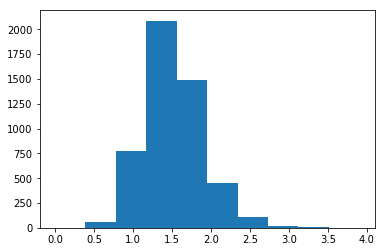

In [24]:
# Maybe get the std of sentence max child count is a good indicator
plt.hist(df_0.DT_max_dp_cnts.apply(lambda x: np.array(x).std()))

**Check the pattern of sentence children counts per country**

In [228]:
df_t = df_0[(df_0['label']=='ENS')|\
          (df_0['label']=='IDN')|(df_0['label']=='PAK')|(df_0['label']=='SIN')]

In [1]:
pwk.plot_pattern(df_t, 'DT_max_dp_cnts', np.mean)

NameError: name 'pwk' is not defined

### Relative positions of ROOT

### compare the sentence length and the index of ROOT shows that ROOT.index doesn't necessarily reflect the sentence length

In [27]:
[{len(s):[i for i,e in enumerate(s.split(' ')) if e=='ROOT']} for s in df_0.DT_archs[1]]

[{122: [13]},
 {107: [2]},
 {29: [2]},
 {45: [1]},
 {108: [3]},
 {65: [6]},
 {64: [8]},
 {118: [5]},
 {48: [2]},
 {138: [3]},
 {55: [2]},
 {167: [4]},
 {82: [11]},
 {109: [4]}]

In [28]:
df_0['DT_ROOT_idx'] = df_0['DT_archs'].apply(lambda x: [[i for i,e in enumerate(s.split(' ')) if e=='ROOT'][0] for s in x])

### It's pretty obvious that different native language group has different mean, so this may be a good feature

(array([ 104.,  376.,  223.,   73.,   16.,    2.,    4.,    1.,    0.,    1.]),
 array([  2.21428571,   4.23285714,   6.25142857,   8.27      ,
         10.28857143,  12.30714286,  14.32571429,  16.34428571,
         18.36285714,  20.38142857,  22.4       ]),
 <a list of 10 Patch objects>)

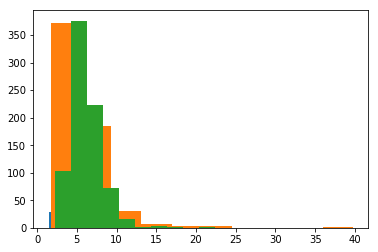

In [37]:
fig, ax = plt.subplots()
ax.hist(df_0[df_0['label']=='ENS'].DT_ROOT_idx.apply(lambda x: np.array(x).mean()))
ax.hist(df_0[df_0['label']=='KOR'].DT_ROOT_idx.apply(lambda x: np.array(x).mean()))
ax.hist(df_0[df_0['label']=='CHN'].DT_ROOT_idx.apply(lambda x: np.array(x).mean()))

### Count of xxpass

In [42]:
df_0['DT_pass_cnt'] = df_0['DT_archs'].apply(lambda x: [len([dep for dep in s.split(' ') if dep[-4:]=='pass']) for s in x])

In [44]:
#df_0['DT_pass_cnt']

(array([ 117.,  108.,   79.,   46.,   28.,    9.,    9.,    3.,    0.,    1.]),
 array([  0.,   2.,   4.,   6.,   8.,  10.,  12.,  14.,  16.,  18.,  20.]),
 <a list of 10 Patch objects>)

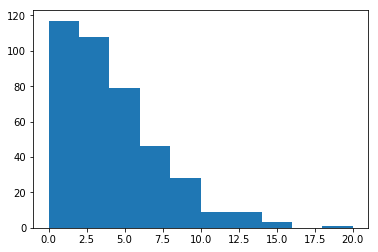

In [49]:
fig, ax = plt.subplots()
ax.hist(df_0[df_0['label']=='ENS'].DT_pass_cnt.apply(lambda x: np.array(x).sum()))
#ax.hist(df_0[df_0['label']=='KOR'].DT_pass_cnt.apply(lambda x: np.array(x).sum()))
#ax.hist(df_0[df_0['label']=='CHN'].DT_pass_cnt.apply(lambda x: np.array(x).sum()))

### Count of 'mark'

In [50]:
df_0['DT_mark_cnt'] = df_0['DT_archs'].apply(lambda x: [len([dep for dep in s.split(' ') if dep=='mark']) for s in x])

(array([  21.,  131.,  127.,  240.,   87.,  124.,   49.,   12.,    5.,    4.]),
 array([  0. ,   1.6,   3.2,   4.8,   6.4,   8. ,   9.6,  11.2,  12.8,
         14.4,  16. ]),
 <a list of 10 Patch objects>)

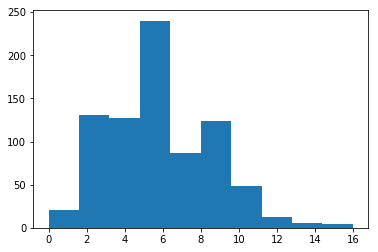

In [53]:
fig, ax = plt.subplots()
#ax.hist(df_0[df_0['label']=='ENS'].DT_mark_cnt.apply(lambda x: np.array(x).sum()))
#ax.hist(df_0[df_0['label']=='KOR'].DT_mark_cnt.apply(lambda x: np.array(x).sum()))
ax.hist(df_0[df_0['label']=='CHN'].DT_mark_cnt.apply(lambda x: np.array(x).sum()))

## Simple models

In [115]:
df_0.columns

Index([u'doc_id', u'path', u'author_code', u'essay_content', u'label',
       u'DT_max_dp_cnts', u'DT_archs', u'DT_ROOT_idx', u'DT_pass_cnt',
       u'DT_mark_cnt', u'POS_adjv_body', u'DT_pos', u'DT_pos_join',
       u'DT_archs_join'],
      dtype='object')

In [ ]:
X = df_0[]
y = df_0['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5)
clf = LogisticRegression()
#clf.fit(X_train_dtm[120:140], y_train[120:140])
clf.fit(X_train_dtm, y_train)
y_pred = clf.predict(X_test_dtm)

In [ ]:
accuracy_score(y_test, y_pred)